<a href="https://colab.research.google.com/github/SiddhantKadwe/TechLab/blob/Maroof/Driver_Drowsiness_Maroof_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import random
import re

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.utils import load_img
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Import Data

In [2]:
# Mounting from Google drive
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/Driver_Drowsiness/Driver_Drowsiness_Dataset.zip"

Mounted at /content/drive


In [3]:
# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []

pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?') #identification criteria of participant

for class_name in os.listdir("Driver Drowsiness Dataset (DDD)"):  #goes through all folders in DDD folder
  for path in os.listdir("Driver Drowsiness Dataset (DDD)/"+class_name):  #goes through all files in both folders and updates file path and labels
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    image_path.append(os.path.join("Driver Drowsiness Dataset (DDD)", class_name, path))
    file_name.append(path)

    person_ID.append(pattern.findall(path)[0])  #identification of participant

print(image_path[0], label[0], file_name[0], person_ID[0])

Driver Drowsiness Dataset (DDD)/Non Drowsy/j0046.png 1 j0046.png j


# Overview of Dataset

In [4]:
# Lists into Dataframe
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['name'] = file_name
df['person'] = person_ID
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

images  label        name person
0  Driver Drowsiness Dataset (DDD)/Non Drowsy/d04...      1   d0454.png      d
1  Driver Drowsiness Dataset (DDD)/Drowsy/ZA0696.png      0  ZA0696.png     ZA
2  Driver Drowsiness Dataset (DDD)/Non Drowsy/x12...      1   x1244.png      x
3  Driver Drowsiness Dataset (DDD)/Non Drowsy/w05...      1   w0508.png      w
4  Driver Drowsiness Dataset (DDD)/Non Drowsy/y10...      1   y1082.png      y
5  Driver Drowsiness Dataset (DDD)/Non Drowsy/za0...      1  za0516.png     za
6   Driver Drowsiness Dataset (DDD)/Drowsy/E0510.png      0   E0510.png      E
7  Driver Drowsiness Dataset (DDD)/Drowsy/ZB1396.png      0  ZB1396.png     ZB
8   Driver Drowsiness Dataset (DDD)/Drowsy/M0108.png      0   M0108.png      M
9  Driver Drowsiness Dataset (DDD)/Non Drowsy/m02...      1   m0260.png      m

In [5]:
df.groupby('label').size()

label
0    22348
1    19445
dtype: int64

In [6]:
df.groupby('person').size()

person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64

In [7]:
temp = df.loc[:,'images']
temp1 = temp[0]
#load_img(temp[0])
print(np.array(load_img(temp[0])).shape)

(227, 227, 3)


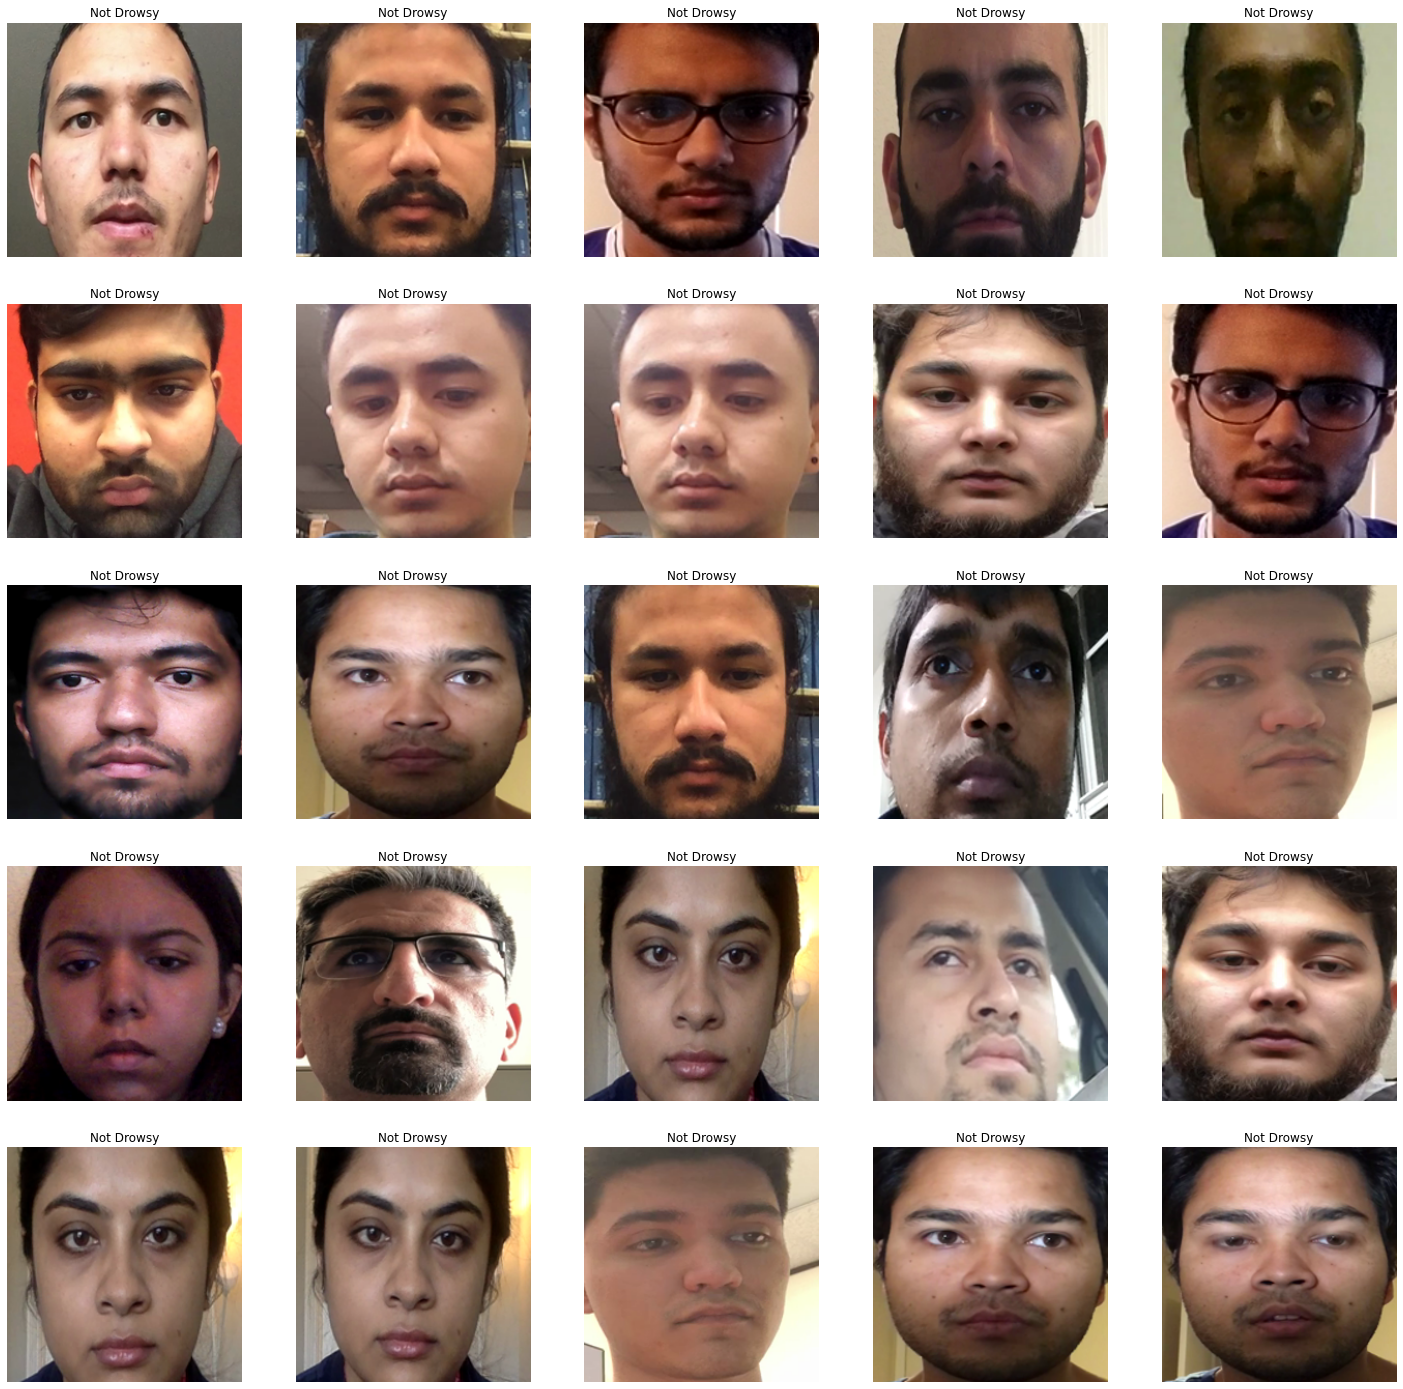

In [8]:
plt.figure(figsize=(25,25))
#temp = df[df['label']==1]['images']   
temp = df.loc[df['label']==1,'images']  #assign all NOT DROWSY image paths to a temp variable
start = random.randint(0, len(temp))
files = temp[start:start+25]  #selection of 25 random images for plotting

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Not Drowsy")
  plt.axis('off')

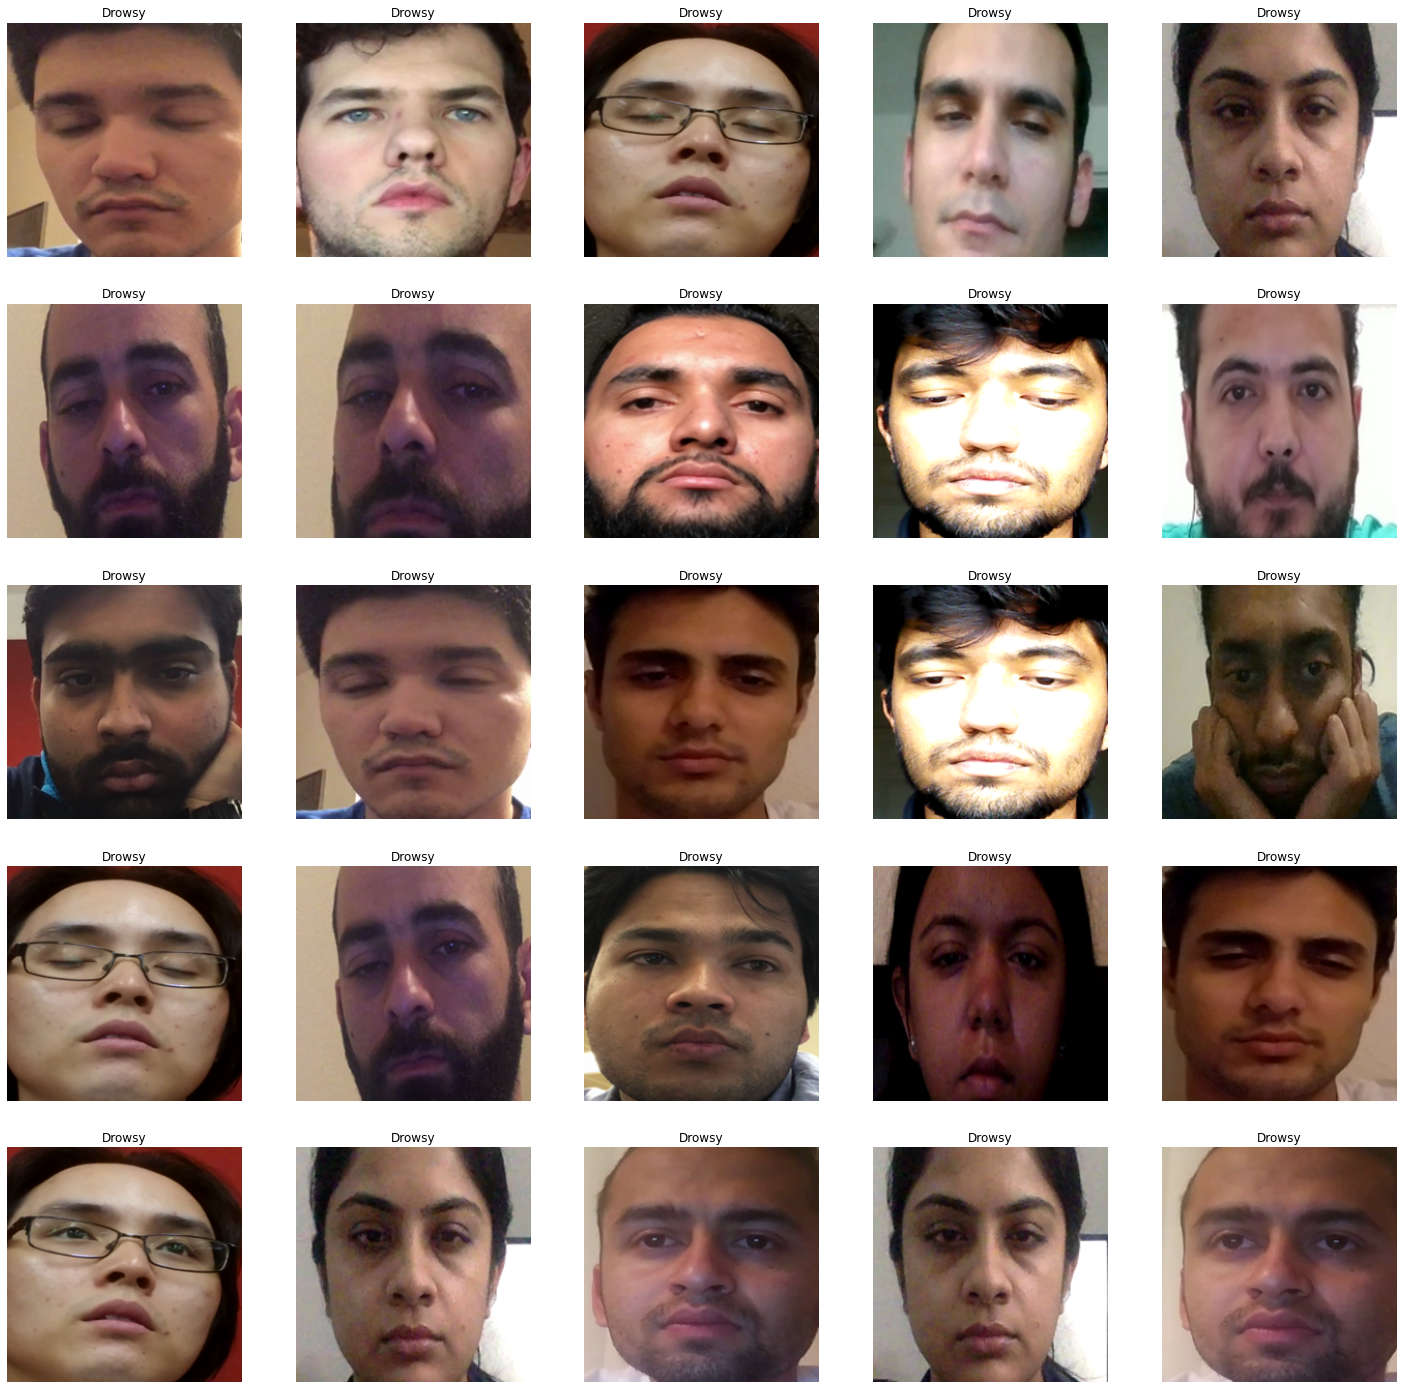

In [9]:
plt.figure(figsize=(25,25))
temp = df.loc[df['label']==0,'images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Drowsy")
  plt.axis('off')

# Preprocessing

In [10]:
df['label'] = df['label'].astype('str')

In [11]:
# train-test split
from sklearn.model_selection import train_test_split
image_path = np.array(image_path).reshape([-1,1])
label = np.array(label).reshape([-1,1])
comp_data = np.hstack((image_path, label))

train, test = train_test_split(comp_data, test_size=0.2, random_state=1234)

In [19]:
transform = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

class DDDdataset(Dataset):
  def __init__(self, image_paths, image_labels, transform):
    super().__init__()
    self.paths = image_paths
    self.labels = image_labels
    self.len = len(self.paths)
    self.transform = transform
  
  def __len__(self): return self.len

  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
    image = Image.open(path).convert('RGB')
    image = self.transform(image)
    return (image, target_tensor)

In [13]:
# create train dataset
train_ds = DDDdataset(train[:,0],train[:,-1], transform)
train_dl = DataLoader(train_ds, batch_size=100)
print(len(train_ds), len(train_dl))

# create test dataset
test_ds = DDDdataset(test[:,0],test[:,-1], transform)
test_dl = DataLoader(test_ds, batch_size=100)
print(len(test_ds), len(test_dl))
print(len(train[:,0]))

33434 335
8359 84
33434


# Model Creation

In [14]:
class DDDConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # convolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # connected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

# Model Training

In [15]:
# Create instance of the model
import time
model = DDDConvNet()

losses = []
accuracies = []
epoches = 3
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Model Training...
for epoch in range(epoches):

    epoch_loss = 0
    epoch_accuracy = 0

    for X, y in train_dl:
        
        preds = model(X)
        loss = loss_fn(preds, y.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        #print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)

    print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))

    # test set accuracy
    with torch.no_grad():

        test_epoch_loss = 0
        test_epoch_accuracy = 0

        for test_X, test_y in test_dl:

            test_preds = model(test_X)
            test_loss = loss_fn(test_preds, test_y.long())

            test_epoch_loss += test_loss            
            test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
            test_epoch_accuracy += test_accuracy

        test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
        test_epoch_loss = test_epoch_loss / len(test_dl)

        print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, time.time() - start))



 --- Epoch: 0, train loss: 0.0962, train acc: 0.9556, time: 243.18473720550537
Epoch: 0, test loss: 0.0076, test acc: 0.9986, time: 287.304612159729


 --- Epoch: 1, train loss: 0.0045, train acc: 0.9987, time: 526.5643622875214
Epoch: 1, test loss: 0.0046, test acc: 0.9986, time: 570.189914226532


 --- Epoch: 2, train loss: 0.0040, train acc: 0.9987, time: 807.5094995498657
Epoch: 2, test loss: 0.0029, test acc: 0.9992, time: 849.8709485530853

